<a href="https://colab.research.google.com/github/dsainvg/Tic-tac-toe-model/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Board

In [ ]:
import torch

class Board:
    def __init__(self):
        self.board = torch.zeros(9, dtype=torch.float32)
        self.sum = 0
        self.game = []

    def printBoard(self):
        for i in range(3):
            print(self.board[i*3:(i+1)*3])

    def _play(self, id, val):
        if self.board[val].item() == 0:
            self.sum += 1
            self.board[val] = id
            self.game.append((id, val))
            return True
        return False

    def _checkWin(self, id, val):
        b = self.board  # shorthand for readability
        match val:
            case 0:
                if (b[0] == b[1]).item() and (b[1] == b[2]).item() and (b[0] == id).item():
                    return True
                if (b[0] == b[3]).item() and (b[3] == b[6]).item() and (b[0] == id).item():
                    return True
                if (b[0] == b[4]).item() and (b[4] == b[8]).item() and (b[0] == id).item():
                    return True
            case 1:
                if (b[0] == b[1]).item() and (b[1] == b[2]).item() and (b[0] == id).item():
                    return True
                if (b[1] == b[4]).item() and (b[4] == b[7]).item() and (b[1] == id).item():
                    return True
            case 2:
                if (b[0] == b[1]).item() and (b[1] == b[2]).item() and (b[0] == id).item():
                    return True
                if (b[2] == b[5]).item() and (b[5] == b[8]).item() and (b[2] == id).item():
                    return True
                if (b[2] == b[4]).item() and (b[4] == b[6]).item() and (b[2] == id).item():
                    return True
            case 3:
                if (b[3] == b[4]).item() and (b[4] == b[5]).item() and (b[3] == id).item():
                    return True
                if (b[0] == b[3]).item() and (b[3] == b[6]).item() and (b[0] == id).item():
                    return True
            case 4:
                if (b[3] == b[4]).item() and (b[4] == b[5]).item() and (b[3] == id).item():
                    return True
                if (b[1] == b[4]).item() and (b[4] == b[7]).item() and (b[1] == id).item():
                    return True
                if (b[0] == b[4]).item() and (b[4] == b[8]).item() and (b[0] == id).item():
                    return True
                if (b[2] == b[4]).item() and (b[4] == b[6]).item() and (b[2] == id).item():
                    return True
            case 5:
                if (b[3] == b[4]).item() and (b[4] == b[5]).item() and (b[3] == id).item():
                    return True
                if (b[2] == b[5]).item() and (b[5] == b[8]).item() and (b[2] == id).item():
                    return True
            case 6:
                if (b[6] == b[7]).item() and (b[7] == b[8]).item() and (b[6] == id).item():
                    return True
                if (b[0] == b[3]).item() and (b[3] == b[6]).item() and (b[0] == id).item():
                    return True
                if (b[2] == b[4]).item() and (b[4] == b[6]).item() and (b[2] == id).item():
                    return True
            case 7:
                if (b[6] == b[7]).item() and (b[7] == b[8]).item() and (b[6] == id).item():
                    return True
                if (b[1] == b[4]).item() and (b[4] == b[7]).item() and (b[1] == id).item():
                    return True
            case 8:
                if (b[6] == b[7]).item() and (b[7] == b[8]).item() and (b[6] == id).item():
                    return True
                if (b[2] == b[5]).item() and (b[5] == b[8]).item() and (b[2] == id).item():
                    return True
                if (b[0] == b[4]).item() and (b[4] == b[8]).item() and (b[0] == id).item():
                    return True
        return False

    def play(self, id, val):
        if self._play(id, val):
            if self._checkWin(id,val):
                return True,"win"
            if self.sum == 9:
                return True,"draw"
            return False,"none"
        return True,"invalid"

    def clear(self):
        self.board = torch.zeros(9, dtype=torch.float32)
        self.sum = 0
        self.game = []

    @property
    def board_state(self):
        return self.board

    @property
    def game_state(self):
        return self.game


# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import torch
import torch.nn as nn
from torch.distributions import Categorical
import os
import pickle
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Board setup and test
board = Board()
# board.printBoard()
# board.board_state

# MODEL

In [ ]:
# Hyperparameters
hyperparams = {
    'input_size': 9,
    'hidden_sizes': (256, 512, 64, 32),
    'num_classes': 9,
    'num_epochs': 5000,
    'num_parallel_boards': 32,
    'game_chances': 9,
    'temperature': 0.60,
    'learning_rate': 7e-4,
    'gamma': 0.85,
    't_end': 0.98,
    'random_t_start': 0.45,
    'random_t_add': 0.5,
    'weight_decay': 1e-3,
    'reward': {"Win": 2, "Lost": -1.9, "Draw": 0.05},
    'device': device,  # Use the device configured above
    'checkpoint_epochs': [2, 10, 100, 500],  # List of epochs to save checkpoints (set to None or [] to disable)
    'checkpoint_dir': '/content/drive/MyDrive/models/checkpoints'  # Directory for checkpoints
}

# Extract model architecture parameters
input_size = hyperparams['input_size']
hidden_sizes = hyperparams['hidden_sizes']
num_classes = hyperparams['num_classes']

### NEURALNET DESIGN

In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(2*input_size, hidden_sizes[0])
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.l3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.l4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.l5 = nn.Linear(hidden_sizes[3], num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        xin = torch.stack((self.relu(x), self.relu(-x)), dim=2).flatten(start_dim=1)
        logits = torch.zeros_like(x)  # Create a tensor of all 0s
        logits = logits.masked_fill(x != 0, float('-inf'))
        out = self.l1(xin)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        out = out + logits
        out = self.softmax(out)
        return out
    
    def _save_checkpoint(self, checkpoint_dir, epoch):
        """Internal method to save a checkpoint"""
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pth')
        torch.save(self.state_dict(), checkpoint_path)
        print(f"  Checkpoint saved: {checkpoint_path}")
    
    def train_model(self, hyperparams, epochs=None):
        """Train the model with given hyperparameters
        
        Args:
            hyperparams: Dictionary of hyperparameters. Include 'checkpoint_epochs' key 
                        with list of epochs to save (e.g., [5, 50, 500, 5000]) to enable checkpointing.
            epochs: Number of epochs to train. If None, uses hyperparams['num_epochs']
        """
        # Extract hyperparameters
        device = hyperparams['device']
        num_epochs = epochs if epochs is not None else hyperparams['num_epochs']
        num_parallel_boards = hyperparams['num_parallel_boards']
        game_chances = hyperparams['game_chances']
        temperature = hyperparams['temperature']
        learning_rate = hyperparams['learning_rate']
        gamma = hyperparams['gamma']
        t_end = hyperparams['t_end']
        random_t_start = hyperparams['random_t_start']
        random_t_add = hyperparams['random_t_add']
        weight_decay = hyperparams['weight_decay']
        reward = hyperparams['reward']
        checkpoint_epochs = hyperparams.get('checkpoint_epochs', None)
        
        # Setup checkpoint directory if needed
        checkpoint_dir = None
        if checkpoint_epochs is not None and len(checkpoint_epochs) > 0:
            checkpoint_dir = hyperparams.get('checkpoint_dir', 'checkpoints')
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_epochs_set = set(checkpoint_epochs)
            print(f"Checkpoints will be saved at epochs: {sorted(checkpoint_epochs_set)}")
            print(f"Checkpoint directory: {checkpoint_dir}")
        
        # Move model to device
        self.to(device)
        
        # Loss and optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        loss_histories = {"avg": [], "cum": []}
        
        # Pre-compute discount cache
        discount_cache = {}
        for length in range(1, game_chances + 1):
            discount_cache[length] = torch.pow(gamma, torch.arange(length, device=device, dtype=torch.float32))
        
        cummulative_loss = 0.0
        avg100 = 0.0
        
        parallel_boards = [Board() for _ in range(num_parallel_boards)]
        all_game_histories = []
        
        # Training loop
        for epoch in range(num_epochs):
            # Clear all boards
            for board in parallel_boards:
                board.clear()
            
            # Generate active players for all boards
            active_players = [1 if random.random() < 0.5 else 0 for _ in range(num_parallel_boards)]
            
            # Track game data for each board
            all_gamequeus = [[] for _ in range(num_parallel_boards)]
            all_boards_states = [[] for _ in range(num_parallel_boards)]
            game_finished = [False] * num_parallel_boards
            final_results = [None] * num_parallel_boards
            
            # Play games on all boards
            for i in range(game_chances):
                active_board_indices = [idx for idx, finished in enumerate(game_finished) if not finished]
                
                if not active_board_indices:
                    break
                
                # Store board states for all active boards
                for board_idx in active_board_indices:
                    all_boards_states[board_idx].append(parallel_boards[board_idx].board_state.clone())
                
                # BATCH PROCESS
                batch_states = torch.stack([parallel_boards[idx].board_state for idx in active_board_indices]).to(device)
                current_player_val = 2*(i%2) - 1
                batch_states = batch_states * current_player_val
                batch_predictions = self(batch_states)
                
                # Process each board's prediction from the batch
                for batch_idx, board_idx in enumerate(active_board_indices):
                    board = parallel_boards[board_idx]
                    active_player = active_players[board_idx]
                    
                    y = batch_predictions[batch_idx].unsqueeze(0)
                    valid_mask = (board.board_state == 0).float().unsqueeze(0).to(device)
                    num_valid = valid_mask.sum()
                    
                    # Mix model predictions with uniform
                    t = temperature + (epoch / num_epochs) * 2 * (1 - temperature)
                    t = min(t, t_end)
                    if active_player != i%2:
                        t = random_t_start + (epoch / num_epochs) * random_t_add
                    uniform_prob = valid_mask / num_valid
                    y = y * t + uniform_prob * (1 - t)
                    m = Categorical(probs=y)
                    Y_out = m.sample()
                    
                    # Make move
                    status, win = board.play(2*(i%2) - 1, Y_out.item())
                    
                    # Store log probability
                    if i % 2 == active_player:
                        log_prob = m.log_prob(Y_out)
                        all_gamequeus[board_idx].append((i, log_prob))
                    
                    # Check if game finished
                    if status:
                        game_finished[board_idx] = True
                        final_results[board_idx] = (status, win)
            
            # Calculate losses
            all_losses = []
            
            for board_idx in range(num_parallel_boards):
                gamequeue = all_gamequeus[board_idx]
                boards_states = all_boards_states[board_idx]
                
                if final_results[board_idx] is None:
                    continue
                
                status, win = final_results[board_idx]
                active_player = active_players[board_idx]
                
                if win == "invalid":
                    if len(boards_states) > 0:
                        print(f"Invalid move made on board {board_idx}!")
                        print("Board state:\n", boards_states[-1].reshape(3,3))
                    continue
                elif len(gamequeue) == 0:
                    continue
                else:
                    # Save game history
                    game_history = {
                        'epoch': epoch,
                        'board_idx': board_idx,
                        'active_player': active_player,
                        'game_state': parallel_boards[board_idx].game_state.copy(),
                        'result': win,
                        'reward': reward["Draw"] if win == "draw" else (reward["Win"] if (len(boards_states) - 1) % 2 == active_player else reward["Lost"])
                    }
                    all_game_histories.append(game_history)
                    
                    if win == "draw":
                        reward_value = reward["Draw"]
                    else:
                        final_i = len(boards_states) - 1
                        reward_value = reward["Win"] if (final_i % 2) == active_player else reward["Lost"]
                    
                    # Stack log_probs
                    log_probs = torch.stack([lp for _, lp in gamequeue[::-1]])
                    discounts = discount_cache[len(gamequeue)]
                    loss = -(discounts * reward_value * log_probs).sum() / len(gamequeue)
                    all_losses.append(loss)
            
            # Update model
            if len(all_losses) > 0:
                optimizer.zero_grad()
                total_loss = torch.stack(all_losses).mean()
                total_loss.backward()
                optimizer.step()
                
                with torch.no_grad():
                    cummulative_loss += total_loss.item()
                    avg100 += total_loss.item()
                
                if (epoch+1) % 100 == 0:
                    loss_histories["avg"].append(avg100)
                    loss_histories["cum"].append(cummulative_loss/(epoch+1))
                    print('epoch ', epoch+1, ': loss = ', total_loss.item(),'; avg loss = ', cummulative_loss/(epoch+1),f"; Avg loss of last 100 is {avg100}", f'; boards processed = {len(all_losses)}')
                    avg100 = 0.0
                    
        return loss_histories, all_game_histories
    
    def train_with_checkpoints(self, hyperparams):
        """Train model saving at specified checkpoint epochs
        
        Args:
            hyperparams: Dictionary with 'checkpoint_epochs' list to train incrementally
        """
        checkpoint_epochs = hyperparams.get('checkpoint_epochs', [])
        if not checkpoint_epochs:
            print("No checkpoint epochs specified, running full training")
            return self.train_model(hyperparams)
        
        checkpoint_dir = hyperparams.get('checkpoint_dir', 'checkpoints')
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        sorted_checkpoints = sorted(checkpoint_epochs)
        all_loss_histories = {"avg": [], "cum": []}
        all_game_histories = []
        
        for checkpoint_epoch in sorted_checkpoints:
            print(f"\n{'='*60}")
            print(f"Training to epoch {checkpoint_epoch}")
            print(f"{'='*60}")
            
            # Train to this checkpoint
            loss_histories, game_histories = self.train_model(hyperparams, epochs=checkpoint_epoch)
            
            # Merge histories
            all_loss_histories["avg"].extend(loss_histories["avg"])
            all_loss_histories["cum"].extend(loss_histories["cum"])
            all_game_histories.extend(game_histories)
            
            # Save checkpoint
            self._save_checkpoint(checkpoint_dir, checkpoint_epoch)
        
        return all_loss_histories, all_game_histories
    
    def save_model(self, model_path, game_histories=None, histories_path=None):
        """Save model and optionally game histories"""
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        
        # Save model
        torch.save(self.state_dict(), model_path)
        print(f"Model saved to {model_path}")
        
        # Save game histories if provided
        if game_histories is not None and histories_path is not None:
            os.makedirs(os.path.dirname(histories_path), exist_ok=True)
            with open(histories_path, 'wb') as f:
                pickle.dump(game_histories, f)
            print(f"Game histories ({len(game_histories)} games) saved to {histories_path}")

model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

In [ ]:
# Training using train_with_checkpoints method
print("Starting training with hyperparameters:")
for key, value in hyperparams.items():
    print(f"  {key}: {value}")

loss_histories, all_game_histories = model.train_with_checkpoints(hyperparams)

epoch  100 : loss =  -1.421303629875183 ; avg loss =  0.6551134525239468 ; Avg loss of last 100 is 65.51134525239468 ; boards processed = 32
epoch  200 : loss =  -1.0251998901367188 ; avg loss =  0.5482449686527252 ; Avg loss of last 100 is 44.13764847815037 ; boards processed = 32
epoch  300 : loss =  0.26413199305534363 ; avg loss =  0.5014485185841719 ; Avg loss of last 100 is 40.785561844706535 ; boards processed = 32
epoch  400 : loss =  -0.933509349822998 ; avg loss =  0.44251935932785275 ; Avg loss of last 100 is 26.57318815588951 ; boards processed = 32
epoch  500 : loss =  -1.360540747642517 ; avg loss =  0.3889719061255455 ; Avg loss of last 100 is 17.47820933163166 ; boards processed = 32
epoch  600 : loss =  0.0787578821182251 ; avg loss =  0.3713825781829655 ; Avg loss of last 100 is 28.34359384700656 ; boards processed = 32
epoch  700 : loss =  1.3132786750793457 ; avg loss =  0.3699610250283565 ; Avg loss of last 100 is 36.14317061007023 ; boards processed = 32
epoch  80

# Saving of model

In [ ]:
# Save model and game histories using the class method
model_filename = '/content/drive/MyDrive/models/model.pth'
histories_filename = '/content/drive/MyDrive/models/game_histories.pkl'

model.save_model(model_filename, game_histories=all_game_histories, histories_path=histories_filename)

Saving model and 160000 game histories to Google Drive...
Model saved to /content/drive/MyDrive/models/model.pth
Game histories saved to /content/drive/MyDrive/models/game_histories.pkl


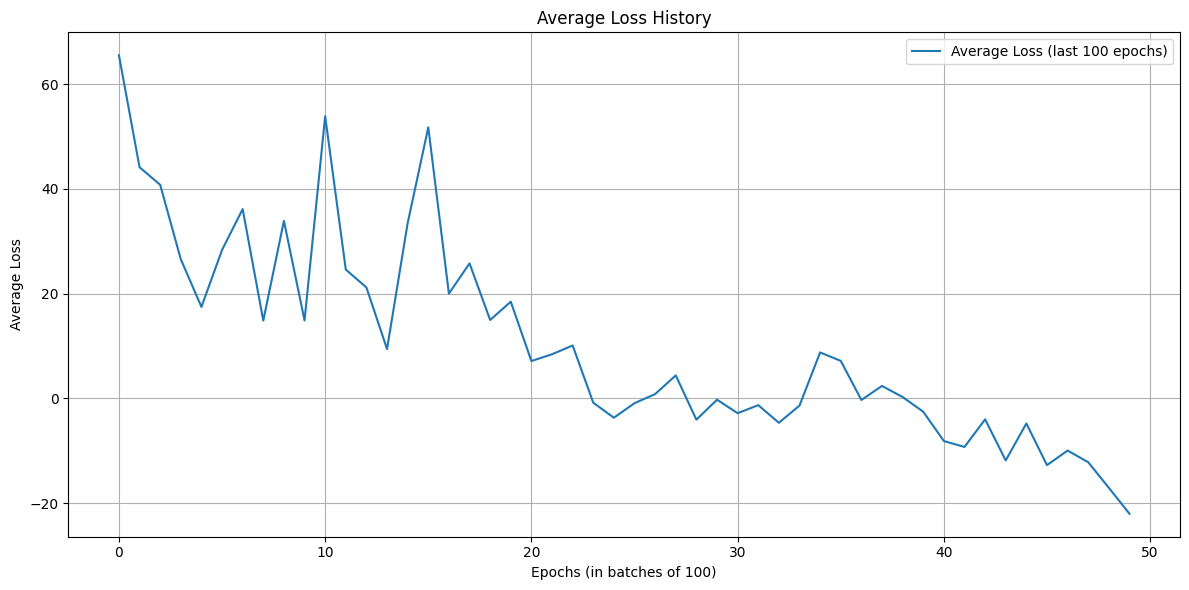

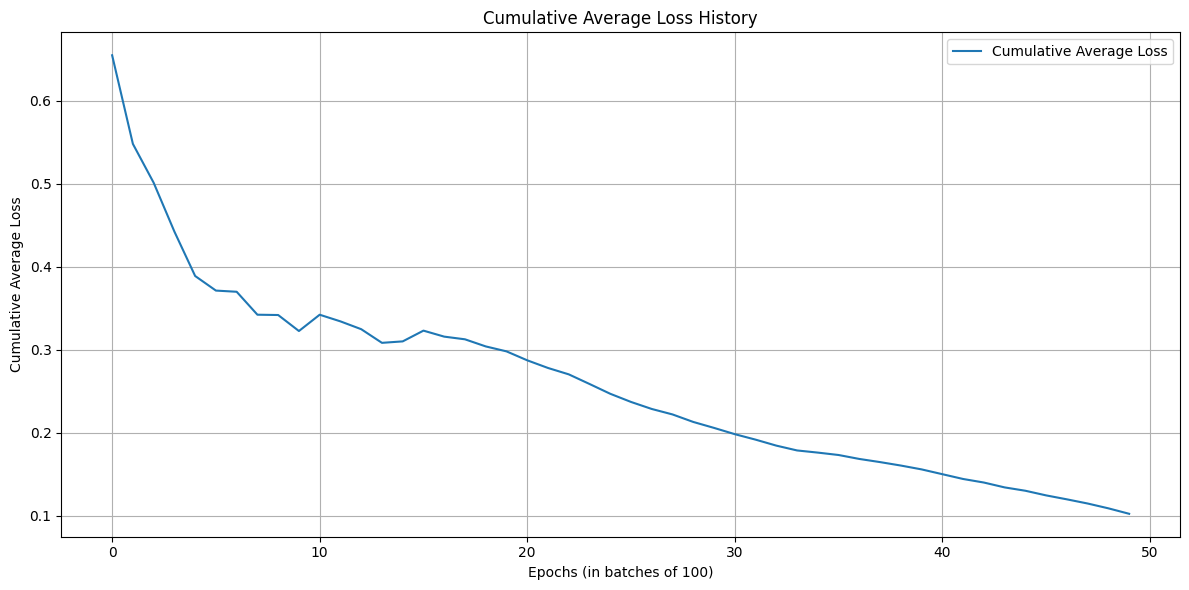

In [ ]:
import matplotlib.pyplot as plt
import os

# Create the models directory if it doesn't exist
output_dir = '/content/drive/MyDrive/models'
os.makedirs(output_dir, exist_ok=True)

# Plot Average Loss History
plt.figure(figsize=(12, 6))
plt.plot(loss_histories["avg"], label='Average Loss (last 100 epochs)')
plt.title("Average Loss History")
plt.xlabel("Epochs (in batches of 100)")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'average_loss_history.png'))
plt.show()

# Plot Cumulative Loss History (if available)
if len(loss_histories["cum"]) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(loss_histories["cum"], label='Cumulative Average Loss')
    plt.title("Cumulative Average Loss History")
    plt.xlabel("Epochs (in batches of 100)")
    plt.ylabel("Cumulative Average Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cumulative_loss_history.png'))
    plt.show()
else:
    print("Cumulative loss history is empty. Please re-run the training cell after the fix.")

In [ ]:
loss_histories["avg"]

[65.51134525239468,
 44.13764847815037,
 40.785561844706535,
 26.57318815588951,
 17.47820933163166,
 28.34359384700656,
 36.14317061007023,
 14.8616823554039,
 33.89773938804865,
 14.895611833781004,
 53.881080970168114,
 24.604718700051308,
 21.190766246058047,
 9.42367084696889,
 33.46932823956013,
 51.75353695452213,
 20.011313430964947,
 25.78090949356556,
 14.984781892970204,
 18.469600927084684,
 7.142103839665651,
 8.438736254349351,
 10.111888972111046,
 -0.8125716280192137,
 -3.6768949907273054,
 -0.8983133500441909,
 0.8352696148212999,
 4.401015327312052,
 -4.048506749328226,
 -0.2339813350699842,
 -2.811762494267896,
 -1.2744936007075012,
 -4.638277917634696,
 -1.3602626691572368,
 8.781200234778225,
 7.177549140993506,
 -0.2898580152541399,
 2.392757643945515,
 0.2705845944583416,
 -2.531066029332578,
 -8.124916538130492,
 -9.255622254684567,
 -3.9890839965082705,
 -11.82261016452685,
 -4.770035130903125,
 -12.72194105386734,
 -9.945600594393909,
 -12.171427947469056,
 -1